# Homework 2 Notebook

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
data = pd.read_csv("9606.hn_HS_CX.edge", sep="\t", header=None)
data.drop([3, 4, 5], axis=1, inplace=True)
data.columns = ["node1", "node2", "weight"]
data.head()

,node1,node2,weight
0,ENSG00000284589,ENSG00000276821,0.000008
1,ENSG00000284589,ENSG00000267534,0.000006
2,ENSG00000284589,ENSG00000178802,0.000006
3,ENSG00000284589,ENSG00000172772,0.000007
4,ENSG00000284589,ENSG00000167751,0.000008


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154387 entries, 0 to 154386
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   node1   154387 non-null  object 
 1   node2   154387 non-null  object 
 2   weight  154387 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.5+ MB


In [4]:
all_nodes = np.array(
    list(set(data["node1"].unique()).union(set(data["node2"].unique())))
)
print("Total number of nodes: {}".format(len(all_nodes)))

Total number of nodes: 10938


First two nodes :

* ENSG00000284589
* ENSG00000276821

## Preprocessing Adjacency Matrix

In [5]:
def create_symmetric_adjacency_matrix(df):
    """
    Create a symmetric adjacency matrix from a dataframe containing edges and weights.
    """
    df_symmetric = pd.concat(
        [df, df.rename(columns={"node1": "node2", "node2": "node1"})]
    )
    df_symmetric = df_symmetric.groupby(["node1", "node2"]).weight.mean().reset_index()

    adjacency_matrix = df_symmetric.pivot(
        index="node1", columns="node2", values="weight"
    ).fillna(0)

    matrix_np = adjacency_matrix.to_numpy()
    symmetrized_matrix_np = matrix_np + matrix_np.T - np.diag(matrix_np.diagonal())

    return symmetrized_matrix_np


def remove_self_loops_and_small_components(adj_matrix, threshold_components=4):
    """
    Remove self-loops and small disconnected components from the graph represented by the adjacency matrix.
    Also, keep track of the removed nodes.
    """
    G = nx.from_numpy_array(adj_matrix)
    removed_nodes = []

    for edge in nx.selfloop_edges(G):
        G.remove_edge(*edge)

    components = list(nx.connected_components(G))
    for component in components:
        if len(component) < threshold_components:
            removed_nodes.extend(component)
            for node in component:
                G.remove_node(node)

    cleaned_adj_matrix = nx.to_numpy_array(G)

    return cleaned_adj_matrix, set(removed_nodes)


def normalize_to_stochastic_matrix(adj_matrix):
    """
    Normalize an adjacency matrix so that each row sums to 1, creating a stochastic matrix.
    """
    matrix_np = np.array(adj_matrix)

    row_sums = matrix_np.sum(axis=1, keepdims=True)

    row_sums[row_sums == 0] = 1

    stochastic_matrix = matrix_np / row_sums

    return stochastic_matrix

In [6]:
adj_mat = create_symmetric_adjacency_matrix(data)
cleaned_adj_mat, removed_nodes = remove_self_loops_and_small_components(adj_mat)

removed_nodes = list(removed_nodes)
all_nodes_cleaned = np.delete(all_nodes, removed_nodes)
avg_degree = np.count_nonzero(cleaned_adj_mat, axis=1).mean()

print(f"Number of removed nodes: {len(removed_nodes)}")
print(f"Number of nodes after cleaning: {len(all_nodes_cleaned)}")
print(f"Average degree: {avg_degree:.1f}")

Number of removed nodes: 113
Number of nodes after cleaning: 10825
Average degree: 28.5


In [ ]:
# save the cleaned graph and list of nodes
G = nx.from_numpy_array(cleaned_adj_mat)
nx.write_weighted_edgelist(G, "./cleaned_graph.edge")
joblib.dump(all_nodes_cleaned, "./cleaned_nodes_arr.pkl")

In [14]:
stochastic_matrix = normalize_to_stochastic_matrix(cleaned_adj_mat)

## Random Walk Without Restart

In [ ]:
def random_walk_without_restart_to_stationary_distribution(
    stochastic_matrix, start_node, threshold=1e-4, max_iterations=1000
):
    """
    Perform a random walk on a graph represented by a stochastic matrix, starting from a given node,
    until the stationary distribution is reached or the maximum number of iterations is exceeded.

    :param stochastic_matrix: The stochastic matrix representing the graph.
    :param start_node: The index of the starting node.
    :param threshold: The threshold for the difference between successive distribution vectors.
    :param max_iterations: The maximum number of iterations to perform.
    :return: The stationary distribution vector of the random walk.
    """
    num_nodes = stochastic_matrix.shape[0]

    q_k = np.zeros(num_nodes)
    q_k[start_node] = 1

    for _ in range(max_iterations):
        q_k_next = np.dot(q_k, stochastic_matrix)

        if np.linalg.norm(q_k_next - q_k) < threshold:
            break

        q_k = q_k_next

    return q_k_next


def visualize_distributions_heatmap(
    *distributions, node_labels=None, distribution_labels=None
):
    """
    Visualize multiple stationary distributions as a heatmap.

    :param distributions: Stationary distributions obtained from random walks.
    :param node_labels: Labels for the nodes (optional).
    :param distribution_labels: Labels for the distributions (optional).
    """
    data = np.vstack(distributions)

    plt.figure(figsize=(15, 5))
    ax = sns.heatmap(
        data,
        annot=False,
        cmap="viridis",
        yticklabels=distribution_labels
        if distribution_labels
        else [f"Dist {i + 1}" for i in range(len(distributions))],
        xticklabels=node_labels if node_labels else [],
    )
    ax.set_title("Comparison of Stationary Distributions from Random Walks")
    ax.set_xlabel("Nodes")
    ax.set_ylabel("Distributions")

    plt.show()

In [ ]:
stationary_distributions = []
for i in range(3):
    start_node = np.random.randint(stochastic_matrix.shape[0])
    print(f"Starting node: {start_node}")
    stationary_distribution = random_walk_without_restart_to_stationary_distribution(
        stochastic_matrix, start_node
    )
    stationary_distributions.append(stationary_distribution)
    print(f"Finished computing stationary distribution for starting node {start_node}")
    print(f"Sum of stationary distribution: {stationary_distribution.sum():.2f}")

In [ ]:
visualize_distributions_heatmap(*stationary_distributions)

As shown by the heatmap above, the Random Walks Without Restart do not preserve the local information of the starting node, effectively annihilating the usefulness of RW without restart for node embedding.

## Random Walk With Restart

In [ ]:
from sklearn.decomposition import PCA

In [11]:
def random_walk_with_restart_to_stationary_distribution(
    stochastic_matrix,
    start_node,
    query_node,
    continue_prob,
    threshold=1e-10,
    max_iterations=1000,
    ignore_threshold=False,
):
    """
    Perform a Random Walk with Restart on a graph represented by a stochastic matrix, starting from a given node,
    until the stationary distribution is reached or the maximum number of iterations is exceeded.

    :param stochastic_matrix: The stochastic matrix representing the graph.
    :param start_node: The index of the starting node.
    :param restart_prob: The probability of restarting to the initial node.
    :param threshold: The threshold for the difference between successive distribution vectors.
    :param max_iterations: The maximum number of iterations to perform.
    :param ignore_threshold: Whether to ignore the threshold and always perform the maximum number of iterations.
    :return: The stationary distribution vector of the random walk.
    """
    num_nodes = stochastic_matrix.shape[0]

    # Initialize the distribution vector q_k and the restart vector v
    q_k = np.zeros(num_nodes)
    q_k[start_node] = 1
    v = np.zeros(num_nodes)
    v[query_node] = 1

    i = 0
    while True:
        if i >= max_iterations:
            print("Maximum number of iterations exceededed.")
            break

        q_k_next = (
            continue_prob * np.dot(q_k, stochastic_matrix) + (1 - continue_prob) * v
        )

        if np.linalg.norm(q_k_next - q_k) < threshold and not ignore_threshold:
            break

        q_k = q_k_next
        i += 1

    print(f"Number of iterations: {i}")

    return q_k_next

In [50]:
def visualize_distributions_heatmap(
    *distributions, node_labels=None, distribution_labels=None, cap_value=None, title=None
):
    """
    Visualize multiple stationary distributions as a heatmap, with an option to cap the highest value.

    :param distributions: Stationary distributions obtained from random walks.
    :param node_labels: Labels for the nodes (optional).
    :param distribution_labels: Labels for the distributions (optional).
    :param cap_value: The value to cap the highest value in the distributions to (optional).
    """
    data = np.vstack(distributions)

    # If cap_value is specified, cap the highest value in the distributions
    if cap_value is not None:
        data = np.where(data > cap_value, cap_value, data)

    plt.figure(figsize=(15, 5))
    ax = sns.heatmap(
        data,
        annot=False,
        cmap="viridis",
        yticklabels=distribution_labels
        if distribution_labels
        else [f"Dist {i + 1}" for i in range(data.shape[0])],
        xticklabels=node_labels if node_labels else [],
    )
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel("Nodes")
    ax.set_ylabel("Distributions")

    plt.show()


def visualize_top_n_node_ranking_scatter_plots(
    distributions, top_n=10, remove_first_n=None, labels=None
):
    """
    Visualize the top N node rankings in each distribution using scatter plots.

    :param distributions: A list of distributions (numpy arrays).
    :param top_n: The number of top nodes to consider.
    :param remove_first_n: The number of top nodes to remove from visualization.
    :param labels: Labels for each distribution.
    """
    plt.figure(figsize=(12, 6))

    for i, distribution in enumerate(distributions):
        # Sort the distribution and pick the top N nodes
        sorted_indices = np.argsort(distribution)

        # Remove the first n nodes if specified
        if remove_first_n is not None:
            sorted_indices = sorted_indices[:-remove_first_n]

        top_nodes_indices = sorted_indices[-top_n:]
        top_nodes_values = distribution[top_nodes_indices]

        # Plotting the top N nodes
        plt.scatter(
            top_nodes_indices,
            top_nodes_values,
            label=f"Distribution {i+1}" if labels is None else labels[i],
            alpha=0.7,
        )

    plt.title(f"Top {top_n} Node Rankings in Each Distribution")
    plt.xlabel("Node Index")
    plt.ylabel("Probability")
    plt.legend()
    plt.show()

def plot_cdf(stationary_distributions, continue_probs, title=None, x_lim=None):
    """
    Plot the Cumulative Distribution Function (CDF) for the stationary distributions of a Random Walk with Restart.

    :param stationary_distributions: List of stationary distribution vectors for different continue probabilities.
    :param continue_probs: List of continue probabilities corresponding to the stationary distributions.
    """
    plt.figure(figsize=(12, 7))
    
    for distribution, prob in zip(stationary_distributions, continue_probs):
        sorted_distribution = np.sort(distribution)
        cdf = np.cumsum(sorted_distribution)
        
        plt.plot(cdf, label=f'p = {prob}', linewidth=2)
    
    
    plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)


    if title is not None:
        plt.title('Cumulative Distribution Function of Stationary Distributions')
    if x_lim is not None:
        plt.xlim(x_lim)
    plt.xlabel('Node Index')
    plt.ylabel('Cumulative Probability')
    plt.tight_layout()
    plt.legend()
    plt.show()

In [7]:
node_1, node_2 = data.loc[0, "node1"], data.loc[0, "node2"]
print(f"Node 1: {node_1}")
print(f"Node 2: {node_2}")

Node 1: ENSG00000284589
Node 2: ENSG00000276821


Restarting nodes :
* Node 1: ENSG00000284589
* Node 2: ENSG00000276821

In [9]:
# find index of node 1 and node 2 in all nodes
node_1_idx = np.where(all_nodes_cleaned == node_1)[0][0]
node_2_idx = np.where(all_nodes_cleaned == node_2)[0][0]
print(f"Node 1 index: {node_1_idx}")
print(f"Node 2 index: {node_2_idx}")

Node 1 index: 9507
Node 2 index: 6483


### Varying restarting probability, fixed restarting node, fixed random starting node

In the first experiment we will fix N1 as the restart node, fix a random q0 as the starting node, and vary the probability of restarting from N1.

In [40]:
continue_probs = [0.2, 0.5, 0.8]
stationary_distributions = []
start_node = 1022
for prob in continue_probs:
    print(f"Starting node: {start_node}")
    print(f"Restarting node: {node_2_idx}")
    print(f"Restart probability: {1 - prob:.2f}")
    stationary_distribution = random_walk_with_restart_to_stationary_distribution(
        stochastic_matrix, start_node, node_2_idx, prob, ignore_threshold=False
    )
    stationary_distributions.append(stationary_distribution)
    print(f"Finished computing stationary distribution for starting node {start_node}")
    print(f"Sum of stationary distribution: {stationary_distribution.sum():.2f}")

Starting node: 1022
Restarting node: 6483
Restart probability: 0.80
Number of iterations: 12
Finished computing stationary distribution for starting node 1022
Sum of stationary distribution: 1.00
Starting node: 1022
Restarting node: 6483
Restart probability: 0.50
Number of iterations: 24
Finished computing stationary distribution for starting node 1022
Sum of stationary distribution: 1.00
Starting node: 1022
Restarting node: 6483
Restart probability: 0.20
Number of iterations: 54
Finished computing stationary distribution for starting node 1022
Sum of stationary distribution: 1.00


In [41]:
stationary_distributions = np.array(stationary_distributions)
stationary_distributions.shape

(3, 10825)

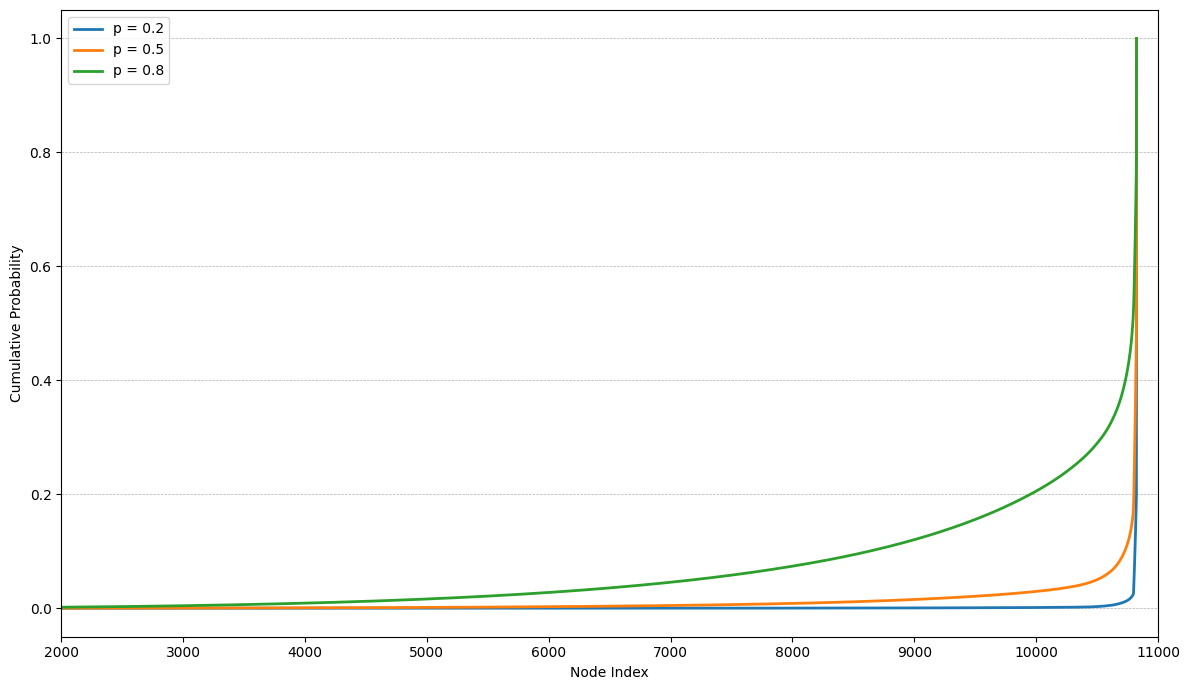

In [42]:
plot_cdf(stationary_distributions, continue_probs,  x_lim=(2000, 11000))

In [ ]:
# find second max value in each distribution
second_max_values = []
for distribution in stationary_distributions:
    sorted_distribution = np.sort(distribution)
    second_max_values.append(sorted_distribution[-2])

second_max_values = np.array(second_max_values) * 100
second_max_values

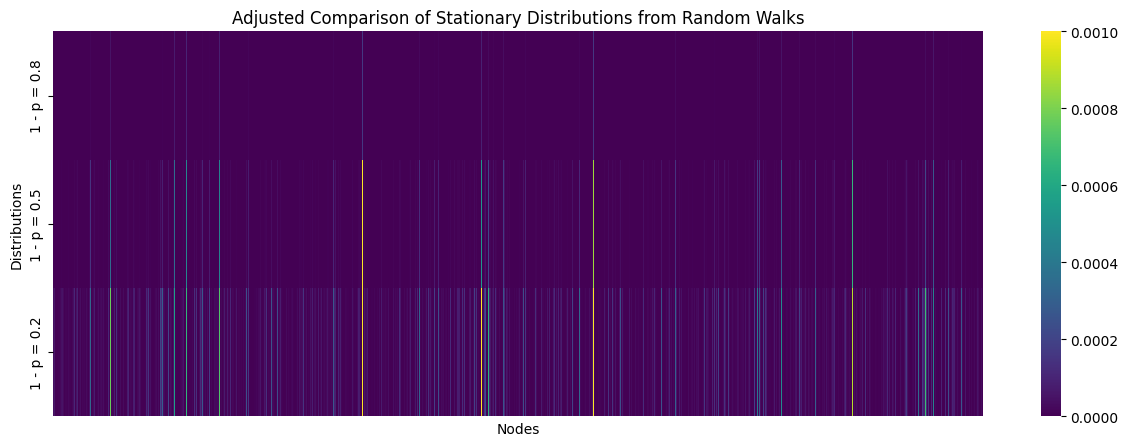

In [47]:
visualize_distributions_heatmap(
    *stationary_distributions,
    cap_value=0.001,
    distribution_labels=[f"1 - p = {1 - prob:.1f}" for prob in continue_probs],
)

In [ ]:
visualize_top_n_node_ranking_scatter_plots(
    stationary_distributions,
    top_n=7,
    remove_first_n=1,
    labels=[f"1 - p = {1 - prob:.1f}" for prob in continue_probs],
)

### Fixing $p=0.2$, varying starting node, fixed restarting node

In [48]:
continue_prob = 0.2
stationary_distributions = []
start_nodes = [1022, 7077, 3204]
for start_node in start_nodes:
    print(f"Starting node: {start_node}")
    print(f"Restarting node: {node_2_idx}")
    print(f"Restart probability: {1 - prob:.2f}")
    stationary_distribution = random_walk_with_restart_to_stationary_distribution(
        stochastic_matrix, start_node, node_2_idx, prob, ignore_threshold=False
    )
    stationary_distributions.append(stationary_distribution)
    print(f"Finished computing stationary distribution for starting node {start_node}")
    print(f"Sum of stationary distribution: {stationary_distribution.sum():.2f}")

Starting node: 1022
Restarting node: 6483
Restart probability: 0.20
Number of iterations: 54
Finished computing stationary distribution for starting node 1022
Sum of stationary distribution: 1.00
Starting node: 7077
Restarting node: 6483
Restart probability: 0.20
Number of iterations: 57
Finished computing stationary distribution for starting node 7077
Sum of stationary distribution: 1.00
Starting node: 3204
Restarting node: 6483
Restart probability: 0.20
Number of iterations: 58
Finished computing stationary distribution for starting node 3204
Sum of stationary distribution: 1.00


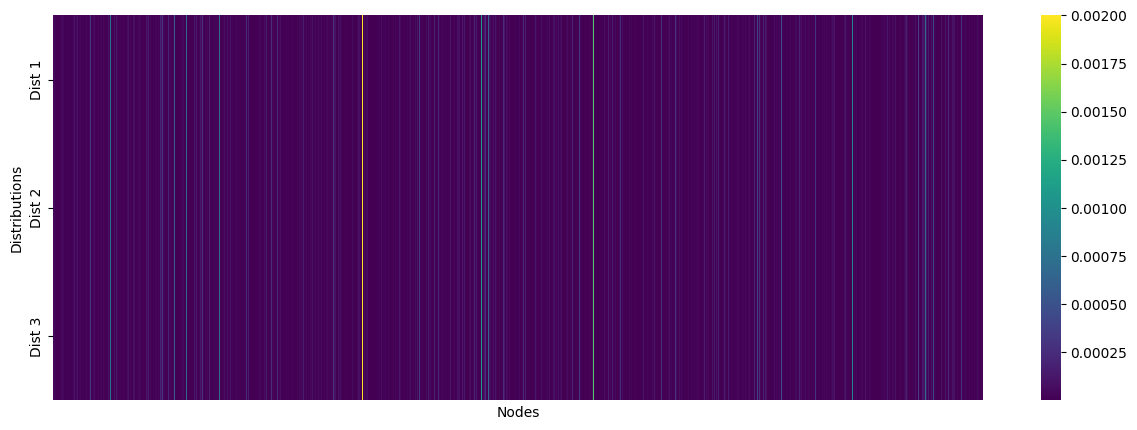

In [53]:
visualize_distributions_heatmap(*stationary_distributions, cap_value=0.002)

In [ ]:
visualize_top_n_node_ranking_scatter_plots(
    stationary_distributions,
    top_n=15,
    remove_first_n=1,
    labels=[f"1 - p = {1 - prob:.1f}" for prob in continue_probs],
)

### Fixing probability $p=0.2$ and Starting Node, Varying Restarting Node

In [54]:
continue_prob = 0.2
stationary_distributions = []
start_nodes = 1022
for restart_node in [node_1_idx, node_2_idx]:
    print(f"Starting node: {start_node}")
    print(f"Restarting node: {restart_node}")
    print(f"Restart probability: {1 - prob:.2f}")
    stationary_distribution = random_walk_with_restart_to_stationary_distribution(
        stochastic_matrix, start_node, restart_node, prob, ignore_threshold=False
    )
    stationary_distributions.append(stationary_distribution)
    print(f"Finished computing stationary distribution for starting node {start_node}")
    print(f"Sum of stationary distribution: {stationary_distribution.sum():.2f}")

Starting node: 3204
Restarting node: 9507
Restart probability: 0.20
Number of iterations: 54
Finished computing stationary distribution for starting node 3204
Sum of stationary distribution: 1.00
Starting node: 3204
Restarting node: 6483
Restart probability: 0.20
Number of iterations: 58
Finished computing stationary distribution for starting node 3204
Sum of stationary distribution: 1.00


In [ ]:
with plt.style.context("seaborn-v0_8-whitegrid"):    
    plt.figure(figsize=(12, 7))
        
    plt.plot(stationary_distribution[0], label=f'Restarting node $N_1$', linewidth=2)
    plt.plot(stationary_distribution[1], label=f'Restarting node $N_2$', linewidth=2)
    
    
    plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

    # plt.xlim(x_lim)
    plt.xlabel('Node Index')
    plt.ylabel('Cumulative Probability')
    plt.tight_layout()
    plt.legend()
    plt.show()

## Node2Vec

Let's generate and compare node2vec embeddings with two different configurations.

In [ ]:
import networkx as nx
from node2vec import Node2Vec
import numpy as np
import joblib
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

### Generating the embeddings

In [ ]:
def generate_and_save_embeddings(G, p, q, search_type):
    node2vec = Node2Vec(G, dimensions=128, walk_length=80, num_walks=10, workers=8, p=p, q=q)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    model.wv.save_word2vec_format(f"./graph_embed_{search_type}.emd")
    model.save(f"./node2vec_{search_type}.model")

In [ ]:
G = nx.read_weighted_edgelist("./cleaned_graph.edge")
G.number_of_nodes()

Typically, we use two sets of configurations :
* (low p, low q) : depth first type of exploration
* (high p, high q) : breadth first type of exploration

In [ ]:
# breadth first search
generate_and_save_embeddings(G, 1, 1, "bfs")

In [ ]:
# depth first search
generate_and_save_embeddings(G, 0.1, 0.1, "dfs")

### Comparing the embeddings

In [ ]:
from scipy.stats import spearmanr
import numpy as np

In [ ]:
def get_node_embedding(file_path, node_name, node_names):
    """
    Reads an embedding file and retrieves the embedding for a specific node.

    Parameters:
    file_path (str): The path to the embedding file.
    node_name (str): The name of the node whose embedding is to be retrieved.
    node_names (list): A list of node names, indexed by their ID in the embedding file.

    Returns:
    list: The embedding of the specified node, or None if the node is not found.
    """
    try:
        # Find the index (ID) of the node
        if node_name not in node_names:
            return None
        node_id = node_names.index(node_name)

        with open(file_path, 'r') as file:
            # Skip the header line
            next(file)

            # Iterate through the file to find the matching node ID
            for line in file:
                parts = line.strip().split()
                if int(parts[0]) == node_id:
                    # Return the embedding (excluding the node ID)
                    return np.array([float(x) for x in parts[1:]])
        
        # Node ID not found in the file
        return None
    except FileNotFoundError:
        print(f"File {file_path} not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [ ]:
all_nodes_cleaned = joblib.load("./cleaned_nodes_arr.pkl")

In [ ]:
n1_embedding_bfs = get_node_embedding("graph_embed_breadth_first.emd", "ENSG00000284589", list(all_nodes_cleaned))
n2_embedding_bfs = get_node_embedding("graph_embed_breadth_first.emd", "ENSG00000276821", list(all_nodes_cleaned))


In [ ]:
n1_embedding_dfs = get_node_embedding("graph_embed_depth_first.emd", "ENSG00000284589", list(all_nodes_cleaned))
n2_embedding_dfs = get_node_embedding("graph_embed_depth_first.emd", "ENSG00000276821", list(all_nodes_cleaned))

In [ ]:
if n1_embedding_bfs is not None and n1_embedding_dfs is not None:
    pearson_corr = np.corrcoef(n1_embedding_bfs, n1_embedding_dfs)[0, 1]
    spearman_corr, _ = spearmanr(n1_embedding_bfs, n1_embedding_dfs)
    print("Spearman Correlation Coefficient:", spearman_corr)
    print("Pearson Correlation Coefficient:", pearson_corr)
else:
    print("One or more embeddings not found.")

In [ ]:
if n2_embedding_bfs is not None and n2_embedding_dfs is not None:
    pearson_corr = np.corrcoef(n2_embedding_bfs, n2_embedding_dfs)[0, 1]
    spearman_corr, _ = spearmanr(n2_embedding_bfs, n2_embedding_dfs)
    print("Spearman Correlation Coefficient:", spearman_corr)
    print("Pearson Correlation Coefficient:", pearson_corr)
else:
    print("One or more embeddings not found.")

In [ ]:
if n1_embedding_bfs is not None and n2_embedding_bfs is not None:
    pearson_corr = np.corrcoef(n1_embedding_bfs, n2_embedding_bfs)[0, 1]
    spearman_corr, _ = spearmanr(n1_embedding_bfs, n2_embedding_bfs)
    print("Spearman Correlation Coefficient:", spearman_corr)
    print("Pearson Correlation Coefficient:", pearson_corr)
else:
    print("One or more embeddings not found.")

In [ ]:
if n1_embedding_dfs is not None and n2_embedding_dfs is not None:
    pearson_corr = np.corrcoef(n1_embedding_dfs, n2_embedding_dfs)[0, 1]
    spearman_corr, _ = spearmanr(n1_embedding_dfs, n2_embedding_dfs)
    print("Spearman Correlation Coefficient:", spearman_corr)
    print("Pearson Correlation Coefficient:", pearson_corr)
else:
    print("One or more embeddings not found.")

In [ ]:
if n1_embedding_bfs is not None and n2_embedding_dfs is not None:
    pearson_corr = np.corrcoef(n1_embedding_bfs, n2_embedding_dfs)[0, 1]
    spearman_corr, _ = spearmanr(n1_embedding_bfs, n2_embedding_dfs)
    print("Spearman Correlation Coefficient:", spearman_corr)
    print("Pearson Correlation Coefficient:", pearson_corr)
else:
    print("One or more embeddings not found.")

In [ ]:
if n1_embedding_dfs is not None and n2_embedding_bfs is not None:
    pearson_corr = np.corrcoef(n1_embedding_dfs, n2_embedding_bfs)[0, 1]
    spearman_corr, _ = spearmanr(n1_embedding_dfs, n2_embedding_bfs)
    print("Spearman Correlation Coefficient:", spearman_corr)
    print("Pearson Correlation Coefficient:", pearson_corr)
else:
    print("One or more embeddings not found.")

Spearman Correlation Coefficients :

| Correlation | N1 bfs | N1 dfs | N2 bfs | N2 dfs |
|-------------|--------|--------|--------|--------|
| N1 bfs      | 1      |        |        |        |
| N1 dfs      | 0.046  | 1      |        |        |
| N2 bfs      | 0.106  | 0.161  | 1      |        |
| N2 dfs      | 0.037  | 0.119  | 0.078  | 1      |

Pearson Correlation Coefficients :

| Correlation | N1 bfs | N1 dfs | N2 bfs | N2 dfs |
|-------------|--------|--------|--------|--------|
| N1 bfs      | 1      |        |        |        |
| N1 dfs      | 0.051  | 1      |        |        |
| N2 bfs      | 0.080  | 0.138  | 1      |        |
| N2 dfs      | 0.051  | 0.128  | 0.088  | 1      |

### Correlation according to p and q

Let's compute the correlations as a function of p and q, then plot the results in a 3D scatter plot.

In [ ]:
def compute_correlations(correlation_type="pearson"):
    p_values = [0.1, 0.3, 0.7, 1.0]
    q_values = [0.1, 0.3, 0.7, 1.0]
    correlations = {'pearson': [], 'spearman': []}
    node_names = list(joblib.load("./cleaned_nodes_arr.pkl"))

    for p in p_values:
        for q in q_values:
            generate_and_save_embeddings(G, p, q, f"p{p}_q{q}")
            emb1 = get_node_embedding(f"./graph_embed_p{p}_q{q}.emd", "ENSG00000284589", node_names)
            emb2 = get_node_embedding(f"./graph_embed_p{p}_q{q}.emd", "ENSG00000276821", node_names)

            if emb1 is not None and emb2 is not None:
                if correlation_type in ["pearson", "both"]:
                    pearson_corr = np.corrcoef(emb1, emb2)[0, 1]
                    correlations['pearson'].append((p, q, pearson_corr))
                if correlation_type in ["spearman", "both"]:
                    spearman_corr, _ = spearmanr(emb1, emb2)
                    correlations['spearman'].append((p, q, spearman_corr))

    return correlations if correlation_type == "both" else {correlation_type: correlations[correlation_type]}

def plot_correlations(correlations_dict):
    fig = plt.figure(figsize=(15, 6))
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(1.0)
    
    nrows, ncols = 1, 2
    
    scatter_plots = []

    for i, (correlation_name, data) in enumerate(correlations_dict.items(), 1):
        ax = fig.add_subplot(nrows, ncols, i, projection='3d')
        ax.patch.set_facecolor('white')
        ps = [p for p, _, _ in data]
        qs = [q for _, q, _ in data]
        corrs = [corr for _, _, corr in data]

        scatter = ax.scatter(ps, qs, corrs, c=corrs, cmap='seismic')
        scatter_plots.append(scatter)
                
        ax.set_xlabel('P value')
        ax.set_ylabel('Q value')
        ax.set_zlabel('Correlation')
        ax.set_title(f'{correlation_name.capitalize()} Correlation')

    plt.subplots_adjust(right=0.8)

    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(scatter_plots[-1], cax=cbar_ax)

    plt.show()

In [ ]:
correlations = compute_correlations(correlation_type="both")
joblib.dump(correlations, "./correlations.pkl")

In [ ]:
correlations = joblib.load("./correlations.pkl")

In [ ]:
with plt.style.context('bmh'):
    plot_correlations(correlations)

## Community Detection

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities, louvain_communities, girvan_newman
import networkx as nx
import random
import joblib
from time import time
import numpy as np

In [ ]:
G = nx.read_weighted_edgelist("./cleaned_graph.edge")
G.number_of_nodes()

### Clusters Generation

In [ ]:
greedy_clusters = list(greedy_modularity_communities(G))

In [ ]:
louvain_clusters = list(louvain_communities(G))

In [ ]:
girvan_clusters = list(girvan_newman(G))

In [ ]:
clusters_dict = {
    'greedy': greedy_clusters,
    'louvain': louvain_clusters,
    'girvan': girvan_clusters
}

joblib.dump(clusters_dict, "./clusters.pkl")

### Clusters Similarity

In [ ]:
greedy_clusters = joblib.load("results/community_clusters/communities_greedy_modularity_communities.pkl")
louvain_clusters = joblib.load("results/community_clusters/communities_louvain.pkl")
len(greedy_clusters), len(louvain_clusters)

In [ ]:
# cuttoff clusters with size <100 
greedy_clusters = [cluster for cluster in greedy_clusters if len(cluster) >= 100]
louvain_clusters = [cluster for cluster in louvain_clusters if len(cluster) >= 100]

In [ ]:
greedy_cluster_sizes = [len(cluster) for cluster in greedy_clusters]
greedy_cluster_sizes.sort(reverse=True)

plt.figure(figsize=(12, 6))
plt.bar(list(range(len(greedy_cluster_sizes))), greedy_cluster_sizes)
# plt.title("Histogram of Cluster Sizes for Greedy Modularity")
plt.xlabel("Cluster Index")
plt.ylabel("Cluster Size")
plt.show()

In [ ]:
louvain_cluster_sizes = [len(cluster) for cluster in louvain_clusters]
louvain_cluster_sizes.sort(reverse=True)

plt.figure(figsize=(12, 6))
plt.bar(list(range(len(louvain_cluster_sizes))), louvain_cluster_sizes)
# plt.title("Histogram of Cluster Sizes for Greedy Modularity")
plt.xlabel("Cluster Index")
plt.ylabel("Cluster Size")
plt.show()

Using the Jaccard similarity score:

In [ ]:
# Define the Jaccard similarity function
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union == 0:
        return 0
    else:
        return intersection / union

# Initialize matrix to store Jaccard similarity values
similarity_matrix = np.zeros((len(louvain_clusters), len(greedy_clusters)))

# Compute Jaccard similarity between each pair of clusters from different algorithms
for i, cluster1 in enumerate(louvain_clusters):
    for j, cluster2 in enumerate(greedy_clusters):
        sim = jaccard_similarity(cluster1, cluster2)
        similarity_matrix[i, j] = sim

fig, ax = plt.subplots(figsize=(12, 8))

cax = ax.imshow(similarity_matrix, cmap='viridis', interpolation='nearest', aspect='auto')

cbar = plt.colorbar(cax, pad=0.04, ticks=[np.nanmin(similarity_matrix), np.nanmax(similarity_matrix)])

ax.set_xlabel('Clusters from Greedy Algorithm')
ax.set_ylabel('Clusters from Louvain Algorithm')

plt.show()

Using the Rand score:

In [ ]:
from sklearn.metrics import rand_score, adjusted_rand_score

In [ ]:
def clusters_to_labels(clusters, num_nodes):
    labels = [-1] * num_nodes
    for cluster_id, cluster in enumerate(clusters):
        for node_id in cluster:
            labels[int(node_id)] = cluster_id
    return labels

In [ ]:
# Number of nodes
num_nodes = 10825

# Convert the frozensets to lists of labels
labels_algo1 = clusters_to_labels(louvain_clusters, num_nodes)
labels_algo2 = clusters_to_labels(greedy_clusters, num_nodes)

rand_index = rand_score(labels_algo1, labels_algo2)
adjusted_rand_index = adjusted_rand_score(labels_algo1, labels_algo2)

print(f"Rand Index: {rand_index:.3f}")
print(f"Adjusted Rand Index: {adjusted_rand_index:.3f}")

### Plotting the Clusters

Let's represent the clusters visually on the graph network.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

colors = list(mcolors.TABLEAU_COLORS.keys())
num_colors = len(colors)
num_colors

In [ ]:
greedy_clusters = joblib.load("results/community_clusters/communities_greedy_modularity_communities.pkl")

In [ ]:
print(f"Number of clusters: {len(greedy_clusters)}")
print(f"Size of biggest cluster: {len(greedy_clusters[0])}")
print(f"Size of smallest cluster: {len(greedy_clusters[-1])}")

In [ ]:
# Sort clusters by size, descending, and take the ten largest
important_clusters = sorted(greedy_clusters, key=len, reverse=True)[:10]

In [ ]:
# Create a color map for nodes in the ten largest clusters
node_color_map = {}
for cluster_id, cluster_nodes in enumerate(important_clusters):
    for node in cluster_nodes:
        node_color_map[node] = colors[cluster_id]  # Assign color to each node

In [ ]:
# Set a default color for all other nodes
default_color = 'grey'
node_colors = [node_color_map.get(node, default_color) for node in G.nodes()]

In [ ]:
# Draw the graph
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.axis('off')  # Turn off the axis
plt.tight_layout()
plt.savefig('results/community_clusters/greedy_modularity_communities.png')

In [ ]:
largest_clusters = sorted(greedy_clusters, key=len, reverse=True)[:10]
for i, cluster in enumerate(largest_clusters):
    largest_clusters[i] = set(cluster)

# Create a subgraph for visualization
nodes_to_include = set.union(*largest_clusters)
subgraph = G.subgraph(nodes_to_include)

# Use spring layout with constraints based on clusters
pos = nx.spring_layout(subgraph, iterations=50)

# Draw nodes
for i, cluster in enumerate(largest_clusters):
    nx.draw_networkx_nodes(subgraph, pos, nodelist=cluster, node_color=colors[i])

# Draw edges with low opacity
nx.draw_networkx_edges(subgraph, pos, alpha=0.1)

# Hide axis
plt.axis('off')

plt.tight_layout()

# Show plot
plt.savefig('results/community_clusters/greedy_modularity_communities_subgraph.png')

### Girvan-Newman computational Analysis

Because the Girvan-Newman algorithm is very computationally expensive, we couldn't run it on the full graph. Let's extract subgraphs of different sizes and compute the time for the algorithm to complete.

In [ ]:
# List of results from each subgraph
girvan_clusters_results = joblib.load('results/community_clusters/girvan_subgraphs_results.pkl')

In [ ]:
sizes = np.sort(np.array([res['size'] for res in girvan_clusters_results]) / 100)
times = np.sort((np.array([res['time'] for res in girvan_clusters_results]) / 3600))

In [ ]:
from scipy.optimize import curve_fit

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

params, _ = curve_fit(exp_func, sizes, times)

extrapolated_sizes = np.linspace(0, 10, 100)
extrapolated_times = exp_func(extrapolated_sizes, *params)

with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.figure(figsize=(10, 6))
    plt.scatter(sizes * 100, times, color='blue', label='Data')
    plt.plot(extrapolated_sizes * 100, extrapolated_times, color='red', label='Exponential Curve')
    plt.xlabel('Size of Subgraph (number of nodes)', fontsize=14)
    plt.ylabel('Time (hours)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    # plt.title('Extrapolation of Time vs Size')
    plt.legend(fontsize=12)
    plt.show()

## Gradient experiments

In [ ]:
import joblib
import matplotlib.pyplot as plt

In [ ]:
loss_histories = joblib.load("./loss_histories_15_epochs.joblib")

In [ ]:
loss_histories.keys()

In [ ]:
def plot_train_test_losses(losses_dict, model_name, save=False):
    train_loss = losses_dict['train_loss']
    test_loss = losses_dict['test_loss']
    activation_function = model_name.split('_')[0]
    num_layers = model_name.split('_')[1]
    with plt.style.context('seaborn-v0_8-darkgrid'):
        plt.figure(figsize=(8, 5))
        plt.plot(train_loss, label='Training Loss')
        plt.plot(test_loss, label='Validation Loss')
        # plt.title(f'Activation Function: {activation_function}, Layers: {num_layers}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.tight_layout()
        plt.legend()
        if save:
            plt.savefig(f'./assets/{model_name}.png')
        else:
            plt.show()

In [ ]:
for model_name, losses_dict in loss_histories.items():
    plot_train_test_losses(losses_dict, model_name, save=True)